In [1]:
import json

with open("data/world_happiness_data.json", "r") as f:
    data = json.load(f)

data_23 = {}
for country in data:
    for year in data[country]:
        if year == "2023":
            data_23[country] = data[country][year]

# Filter out countries that have attributes missing
data_cleaned = {}
for country, attributes in data_23.items():
    if all(attributes.values()):
        data_cleaned[country] = attributes

print(str(len(data_23) - len(data_cleaned)) + " countries were removed:")
# Print countries taken out
for country in data_23:
    if country not in data_cleaned:
        print(country)

# Convert everything to numeric
for country, attributes in data_cleaned.items():
    for attribute, value in attributes.items():
        data_cleaned[country][attribute] = float(value)

18 countries were removed:
Afghanistan
Bahrain
China
Cyprus
Egypt
Kosovo
Kuwait
Libya
Malta
Niger
Saudi Arabia
Singapore
State of Palestine
Taiwan Province of China
Tajikistan
United Arab Emirates
Venezuela
Yemen


# Linear Regression

## Model

In [2]:
import pandas as pd
import statsmodels.api as sm

df = pd.DataFrame(data_cleaned).T

X = df.drop("Life Ladder", axis=1)
X = sm.add_constant(X)
y = df["Life Ladder"]

model = sm.OLS(y, X).fit()

model.summary()

/Users/cwmitz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Life Ladder   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     61.80
Date:                Thu, 09 May 2024   Prob (F-statistic):           2.25e-37
Time:                        10:23:02   Log-Likelihood:                -78.248
No. Observations:                 120   AIC:                             174.5
Df Residuals:                     111   BIC:                             199.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -2.6315      0.888     -2.964      0.004      -4.391      -0.872
Log GDP per capita                   0.2161      0.095      2.274      0.025       0.028       0.404
Social support                       3.4737      0.653      5.318      0.000       2.179       4.768
Healthy life expectancy at birth     0.0260      0.017      1.535      0.128      -0.008       0.060
Freedom to make life choices         1.4769      0.513      2.880      0.005       0.461       2.493
Generosity                          -0.2821      0.289     -0.976      0.331      -0.855       0.290
Perceptions of corruption           -1.0753      0.308     -3.491      0.001      -1.686      -0.465
Positive affect                      1.6737      0.530      3.159      0.002       0.624       2.724
Negative affect                      0.9449      0.692      1.366      0.175      -0.425       2.315
==============================================================================
Omnibus:                       30.502   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.071
Skew:                          -1.064   Prob(JB):                     9.03e-14
Kurtosis:                       5.736   Cond. No.                     1.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Scatterplots

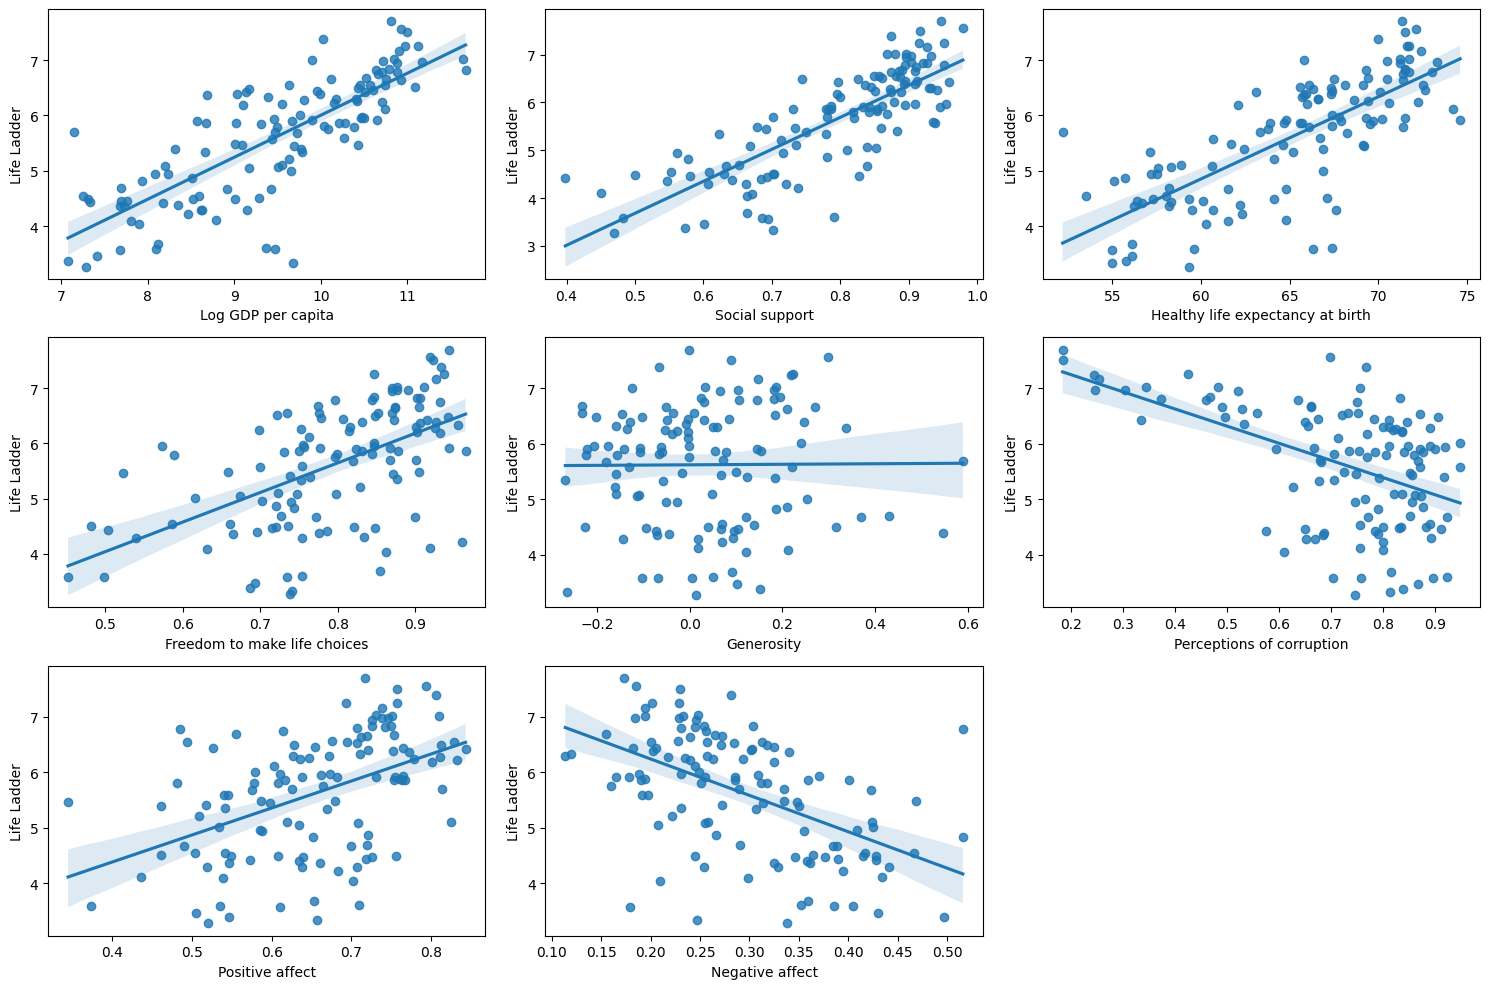

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

n_predictors = len(X.columns) - 1
ncols = 3
nrows = (n_predictors + ncols - 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
axs = axs.flatten()

for idx, feature in enumerate(X.columns[1:]):
    sns.regplot(x=feature, y='Life Ladder', data=df, ax=axs[idx])

for ax in axs[n_predictors:]:
    ax.remove()

plt.tight_layout()
plt.show()


## Residuals

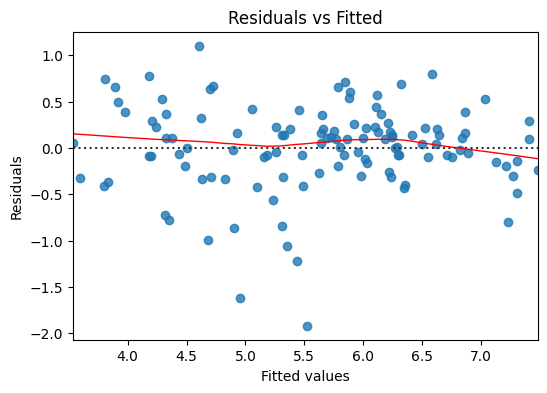

In [4]:
# Residual plot
plt.figure(figsize=(6, 4))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()


## Q-Q Plot

<Figure size 600x400 with 0 Axes>

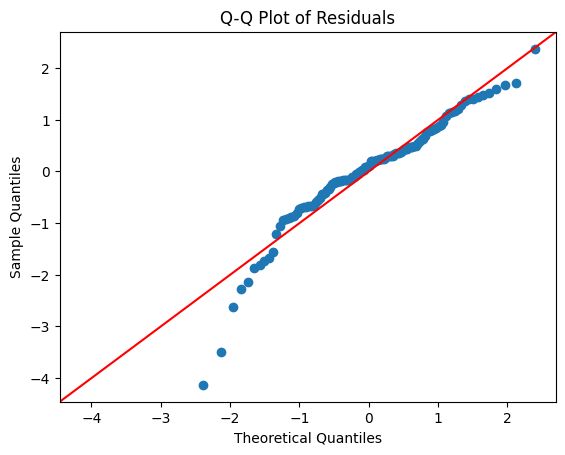

In [5]:
# Q-Q plot for normality check of residuals
fig = plt.figure(figsize=(6, 4))
sm.qqplot(model.resid, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

## Coefficient Plot

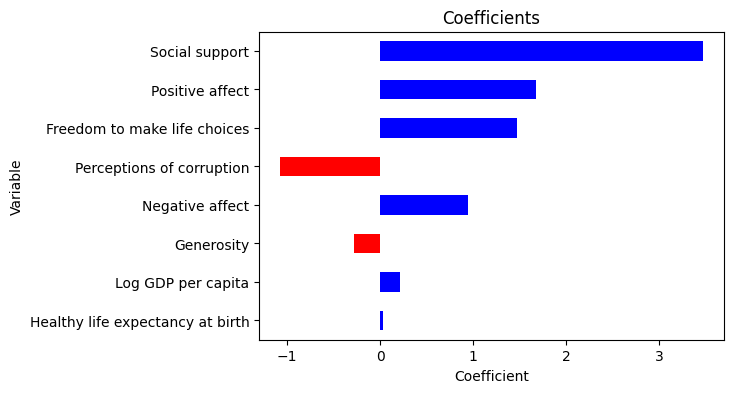

In [6]:
# Coefficient plot
coefs = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': model.params,
    'Std Error': model.bse
})
coefs = coefs.iloc[1:]  # Skip the constant term
coefs['Abs Coef'] = coefs['Coefficient'].abs()
coefs = coefs.sort_values('Abs Coef', ascending=True)

plt.figure(figsize=(6, 4))
coefs['Coefficient'].plot(kind='barh', color=(coefs['Coefficient'] > 0).map({True: 'b', False: 'r'}))
plt.title('Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

# Clustering

In [23]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Convert the dictionary to a DataFrame
df = pd.DataFrame(data_cleaned).T

# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Apply k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(scaled_data)

# Attach cluster labels to the original data
df['Cluster'] = clusters


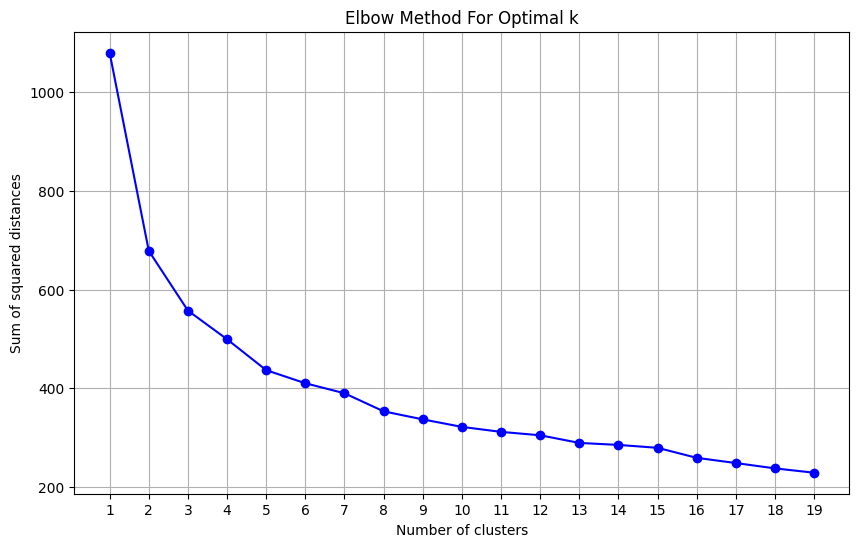

In [24]:
import matplotlib.pyplot as plt

# Range of possible clusters to evaluate
K = range(1, 20)

# Sum of squared distances
ssd = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    ssd.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K, ssd, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()

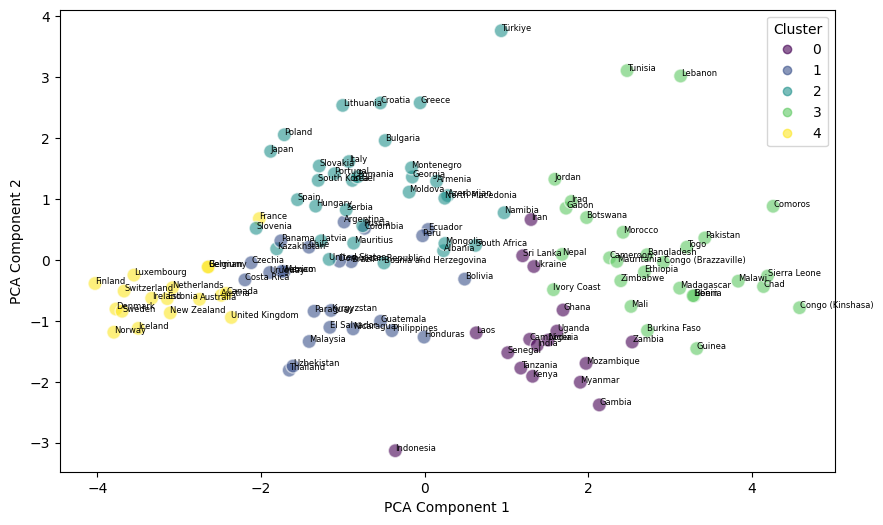

PCA Component 1: -0.44*Life Ladder + -0.41*Log GDP per capita + -0.41*Social support + -0.39*Healthy life expectancy at birth + -0.30*Freedom to make life choices + -0.01*Generosity + 0.26*Perceptions of corruption + -0.25*Positive affect + 0.33*Negative affect
PCA Component 2: 0.02*Life Ladder + 0.30*Log GDP per capita + 0.15*Social support + 0.29*Healthy life expectancy at birth + -0.41*Freedom to make life choices + -0.58*Generosity + 0.17*Perceptions of corruption + -0.51*Positive affect + 0.01*Negative affect


In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducing dimensions with PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Scatter plot of the PCA result
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolors='w', s=100)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# Legend
plt.legend(*scatter.legend_elements(), title='Cluster')

# Labels
for i, country in enumerate(df.index):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], country, fontsize=6)

plt.show()

# See the equation of each PCA component
print("PCA Component 1: " + " + ".join([f"{coef:.2f}*{col}" for coef, col in zip(pca.components_[0], df.columns)]))
print("PCA Component 2: " + " + ".join([f"{coef:.2f}*{col}" for coef, col in zip(pca.components_[1], df.columns)]))


In [26]:
import json
import csv

with open("data/life_ladder.json", "r") as f:
    data = json.load(f)

with open("data/world_regions.csv") as f:
    reader = csv.DictReader(f)
    country_to_region = {}
    for row in reader:
        country_to_region[row["Entity"]] = row[
            "world-regions-according-to-the-united-nations"
        ]

    region_to_countries = {}
    for country, region in country_to_region.items():
        if region not in region_to_countries:
            region_to_countries[region] = set()
        region_to_countries[region].add(country)

In [30]:
# See how many countries from each cluster are in each region
cluster_to_region = {}
for country, cluster in df["Cluster"].items():
    region = country_to_region[country]
    if cluster not in cluster_to_region:
        cluster_to_region[cluster] = {}
    if region not in cluster_to_region[cluster]:
        cluster_to_region[cluster][region] = 0
    cluster_to_region[cluster][region] += 1

# Print the results
for cluster, region_counts in cluster_to_region.items():
    print(f"Cluster {cluster}")
    for region, count in region_counts.items():
        print(f"{region}: {count}")
    print()


Cluster 2
Europe and Northern America: 21
Northern Africa and Western Asia: 5
Eastern and South-Eastern Asia: 3
Central and Southern Asia: 1
Sub-Saharan Africa: 3

Cluster 1
Latin America and Caribbean: 17
Europe and Northern America: 1
Central and Southern Asia: 2
Eastern and South-Eastern Asia: 4

Cluster 4
Oceania: 2
Europe and Northern America: 16

Cluster 3
Central and Southern Asia: 3
Sub-Saharan Africa: 20
Northern Africa and Western Asia: 5

Cluster 0
Eastern and South-Eastern Asia: 4
Sub-Saharan Africa: 9
Central and Southern Asia: 3
Europe and Northern America: 1

